# Ad Campaign Bayesian A/B Test and Analysis
#### by Justin R. Papreck

*This dataset comes from https://www.kaggle.com/datasets/farhadzeynalli/online-advertising-effectiveness-study-ab-testing by Farhad Zeynalli*

---

**Background**
A large company with a substantial user base plans to increase sales through advertisement on its website. However, they are undecided about whether the ads increase sales or not. In order to determine whether this is the case, 20,000 customers were subjected to A/B testing for 31 days. Prior to the A/B testing, the company has reported an approximate 3% conversion, which is enough information to use as a _prior_ for the Bayesian analysis.  

Each customer was assigned a unique identifier, and the groups were split in a 60:40 ratio, with the larger group seeing the new advertisement and the smaller group seeing a public service announcement (psa) in its place. The outcome measured was whether the client made a purchase, delivered as a boolean statement. Additional parameters and metrics collected included the day of the month the user saw the most ads, the hour of the day the user saw the most ads, and the total number of ads seen by each user. 

The company has contracted the analysis out with the above information. 

**New Analysis**
I have previously used these data in the project [Ad Campaign A/B Testing and Recommendations](https://github.com/FreshOats/Marketing_Analysis), using a traditional Z-test to determine whether there was a statistical difference between the two groups. In this case, because we have information about prior behavior, we have a prior probability that can be used in coordination with a Beta Distribution for our analysis. In this case, we can use a weak prior, Beta(3,97) representing the 3 conversions and 97 non-conversions. Since we have collected 20,000 customers' data, the updated $\alpha$ and $\beta$ values will strengthen the distributions based on our prior. Additionally, since this A/B test is only examining a sample of 20,000 people, there is a chance, albeit very low given our previous test, that the sample is not truly representative of the population. To account for this, I am using a Monte Carlo simulation to add variance to the sample to get a broader distribution. 

One benefit that comes from this use of Bayes' Theory in conjunction with the Monte Carlo simulation is that not only can we determine **if** there is a significant difference, or ideally whether the new ad campaign is significantly better, we can also show **how much** better or worse the new ad campaign is compared to that of the psa. 


---
## Bayes' Theorem

The idea behind Bayesian statistics is that it is possible to arrive at the probability of event A given B occured, P(A|B), using the probability of event B given A, P(B|A). This allows us to use the probability of an observation given a belief to determining the strength of that belief given the observation (Kurt, 2019). 

P(A|B) = P(B|A) * P(A) / P(B)

or in terms reflected as above: 

P(belief | obervations) = P(observations | belief) * P(belief) / P(observations)

P(belief | observations) == "Posterior"
P(observations | belief) == "Likelihood"
P(belief) == "Prior Probability" or "Prior"
P(observation) == "Normalizes Probabilities"

**The Prior Probability**
If we don't know the exact prior probability, then a Beta distribution can be used to represent a family of probability distributions for binomial distributions. The Beta distribution provides instead of a single probability, a function of conversion rates and associated densities. So our prior distribution would be as follows: 

Beta($\alpha$<sub>prior</sub>, $\beta$<sub>prior</sub>)

where $\alpha$ is the number of conversions and $\beta$ is the number of non-conversions

In [117]:
library(ggplot2)
library(dplyr)
library(tidyr)

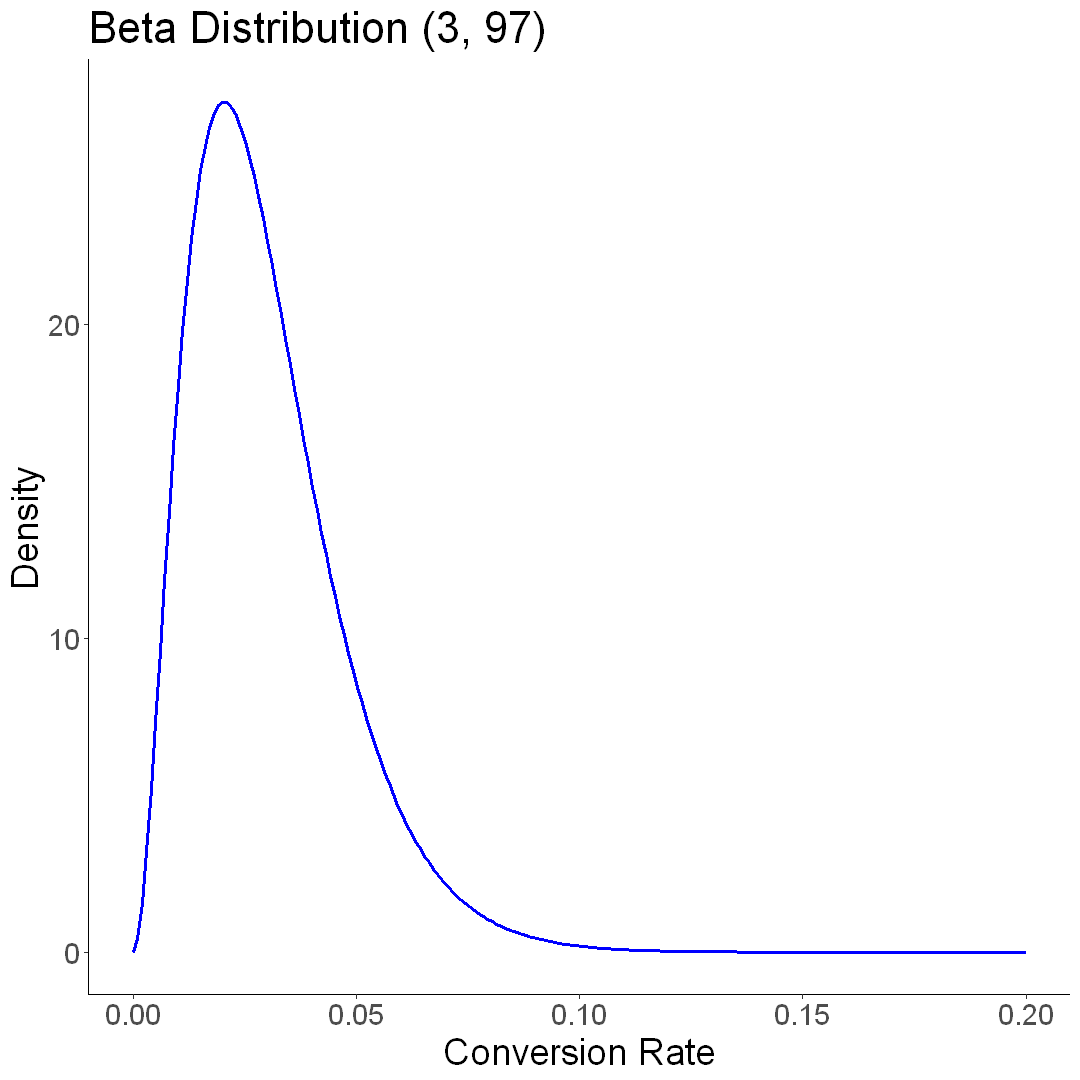

In [131]:

# define range
p <- seq(0, .2, length = 200)

# create a plot of the Beta of 3, 97
alpha <- 3
beta <- 97

df <- data.frame(p, y = dbeta(p, alpha, beta))

options(repr.plot.width =9, repr.plot.height =9)

ggplot(df, aes(x = p, y = y)) +
    geom_line(color = "blue", linewidth = 1) +
    labs(
        x = "Conversion Rate"
        , y = "Density"
        , title = "Beta Distribution (3, 97)"
    ) + 
    theme_classic() +
    theme(text = element_text(size = 22))
    

# plot(p, dbeta(p, alpha, beta), type = "l", ylab = "Density", xlab = "Conversion Rate", col = "blue", main = "Beta Distribution")

This same nomenclature is used for the likelihood and the poseterior. 
So applying Bayes' Theorem to the Beta Distribution, we get the following: 

**Beta($\alpha$<sub>posterior</sub>, $\beta$<sub>posterior</sub>) = Beta($\alpha$<sub>prior</sub> + $\alpha$<sub>likelihood</sub>, $\beta$<sub>prior</sub> + $\beta$<sub>likelihood</sub>)**

Since we will have 2 groups, group **A** and group **B**, or in our case **Ad** and **PSA**, there will be 2 different Beta distributions using the same prior distribution for each, but then the observations will provide the likelihoods of choosing A and choosing B, which are added to the priors. 

---
## Monte Carlo Simulations

In the case where there is an overlap in the probability distributions, there is the introduction of the possibility that the true probability for B is higher than the true probability of A or _vice versa_. The Monte Carlo simulation uses random sampling such that the samples in the high-probability region occur more frequently than those in low-probability regions in _n_ number of simulations. The rbeta() function in R allows us to generate random numers from the beta density with _n_ trials, returning our A and B samples. Using these values we can show the distribution of the probability that A is better/worse than B. 


--- 
## Data Exploration and Cleaning

During the exploratory analysis, I want to determine the following: 

- Length of Table
- Presence of Duplicates
- Number of observations per group
- Presence of Null Values
- Number of Dependent Variable Results
- Distribution of Days
- Distribution of Hours
- Distribution of Ad Counts

In [1]:
# Import the data
ab <- read.csv("online_ad_AB.csv")
head(ab)

,customerID,test.group,made_purchase,days_with_most_add,peak.ad.hours,ad_count
,<int>,<chr>,<lgl>,<int>,<int>,<int>
1,1,ad,FALSE,24,20,5
2,2,psa,FALSE,21,16,9
3,3,psa,FALSE,1,18,8
4,4,ad,FALSE,20,23,7
5,5,ad,FALSE,3,13,5
6,6,ad,FALSE,13,22,7


In [120]:
# Calculate length of dataframe
length <- nrow(ab)

# Calculate the number of duplicate rows
dupes <- sum(duplicated(ab))

# Calculate the count of each group in 'test group'
groups <- table(ab$test.group)

# Calculate the number of null values
nulls <- sum(is.na(ab))

# Calculate the count of each category in 'made_purchase'
purchased <- table(ab$made_purchase)

# Print the results
cat(sprintf("The dataframe has %d rows. The number of duplicate rows is %d.\n", length, dupes))
cat(sprintf("We expected to see a 40:60 ratio of PSA:Ad observations. The actual distribution is %d PSAs to %d Ads, which is not exactly a 40:60 ratio, but close.\n", groups[2], groups[1]))
cat(sprintf("The number of nulls across all columns and rows was %d. There were %d clients that purchased the product and %d that did not.\n", nulls, purchased[2], purchased[1]))

The dataframe has 20000 rows. The number of duplicate rows is 0.
We expected to see a 40:60 ratio of PSA:Ad observations. The actual distribution is 7947 PSAs to 12053 Ads, which is not exactly a 40:60 ratio, but close.
The number of nulls across all columns and rows was 0. There were 1060 clients that purchased the product and 18940 that did not.


In [121]:
null_counts <- colSums(is.na(ab))
print(null_counts)

        customerID         test.group      made_purchase days_with_most_add 
                 0                  0                  0                  0 
     peak.ad.hours           ad_count 
                 0                  0 


There are no nulls in any of the columns, thanks to the Data Source provider. 

The lack of naming convention is annoying, so let's go ahead and change that -> 

In [122]:
# Define the mapping of column names
new_columns <- c(
    "customerID" = "customer_ID"
    , "test.group" = "test_group"
    , "made_purchase" = "converted"
    , "days_with_most_add" = "date_with_most_impressions"
    , "peak.ad.hours" = "time_with_most_impressions"
    , "ad_count" = "total_user_impressions"
)

# Rename the columns
names(ab) <- new_columns

# Print the first few rows
head(ab)

,customer_ID,test_group,converted,date_with_most_impressions,time_with_most_impressions,total_user_impressions
,<int>,<chr>,<lgl>,<int>,<int>,<int>
1,1,ad,FALSE,24,20,5
2,2,psa,FALSE,21,16,9
3,3,psa,FALSE,1,18,8
4,4,ad,FALSE,20,23,7
5,5,ad,FALSE,3,13,5
6,6,ad,FALSE,13,22,7


Now to look at the Distributions

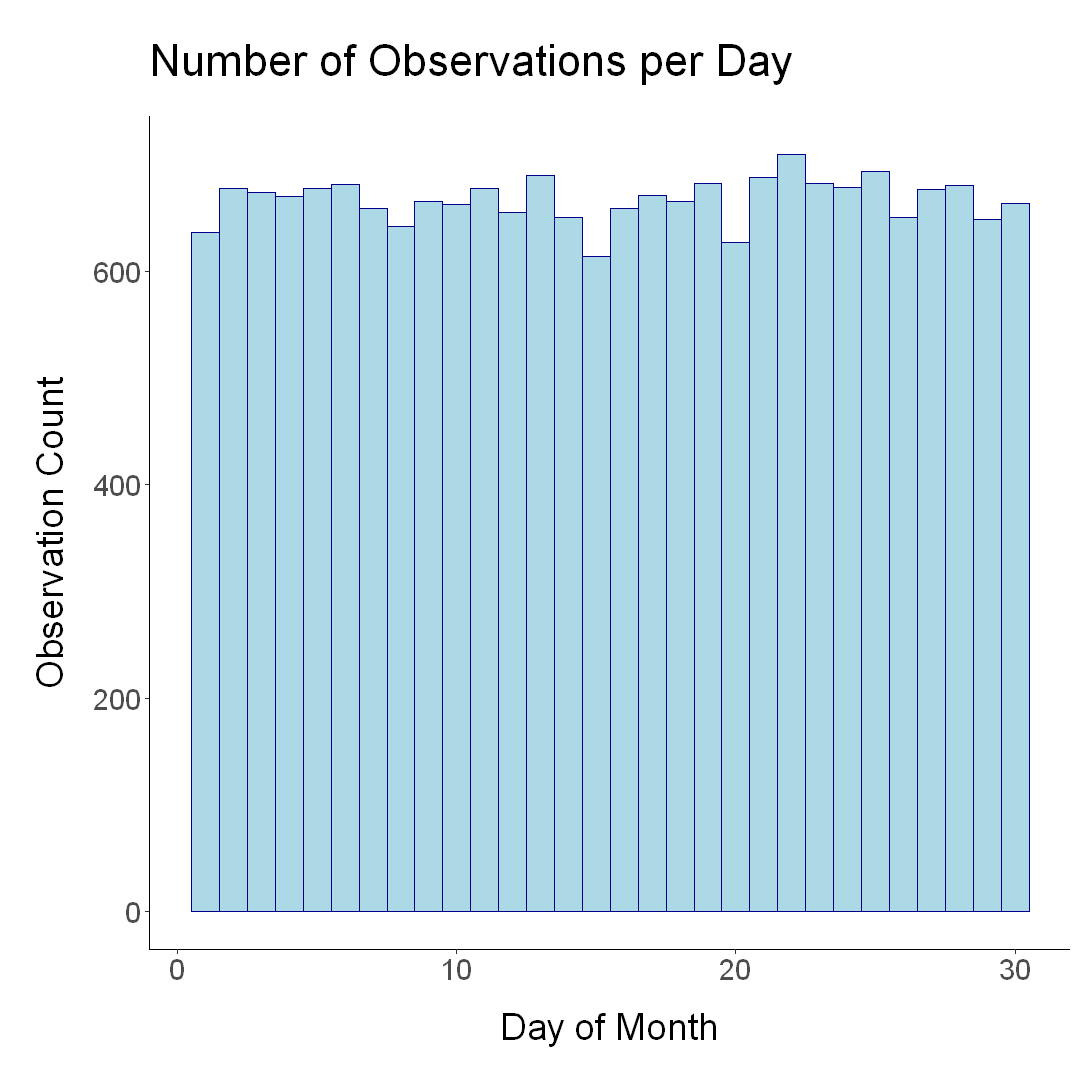

In [123]:
ggplot(data = ab, aes(x = date_with_most_impressions)) +
  geom_histogram(bins = 30, color = 'darkblue', fill = 'lightblue') +
  labs(
        x = "Day of Month"
        , y = "Observation Count"
        , title = "Number of Observations per Day"
    ) + 
    theme_classic() +
    theme(text = element_text(size = 22)) + 
    theme(plot.title = element_text(margin = margin(20,0,20,0))
        , axis.title.x = element_text(margin = margin(15,0,15,0)) 
        , axis.title.y = element_text(margin = margin(0,15,0,15)))

In [124]:
# Find the maximum and minimum number of value counts
counts <- ab %>% count(date_with_most_impressions)

cat(sprintf("The maximum number of site visits on any given day was %d visits, and the miniumum was %d.\n", max(counts[2]), min(counts[2])))

The maximum number of site visits on any given day was 709 visits, and the miniumum was 614.


The number of observations by day of month is an interesting measure. Each user was shown a different number of ads or psa on different days of the month. The days_with_most_add parameter shows us the date of the month when that user saw the most ads. What the count is showing us here is the number of users per date that had their highest number of ads seen on that date. We also have the data of the total ad count per user, but it is unclear if this count is representative of the number of ads or psas seen on that date.  

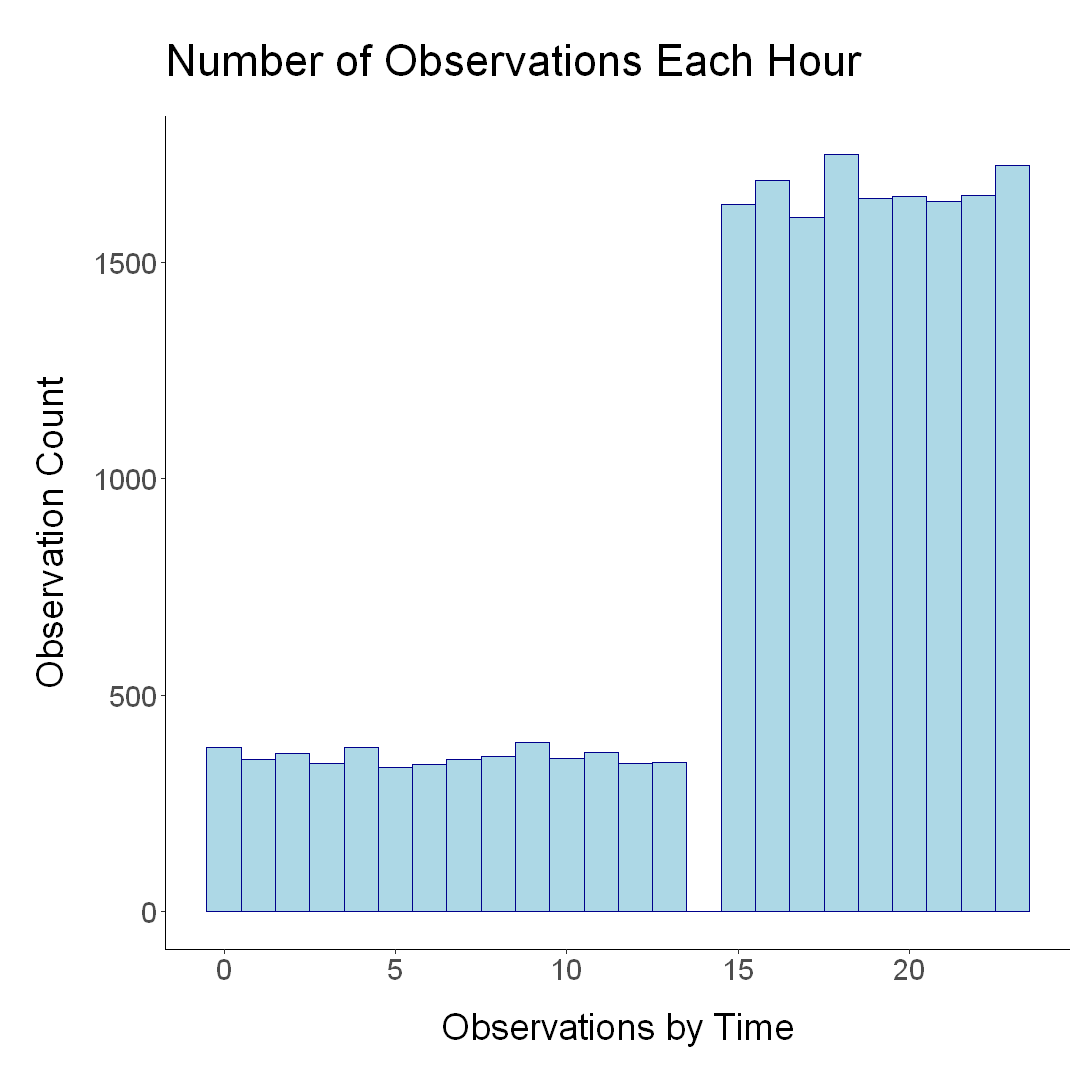

In [125]:
ggplot(data = ab, aes(x = time_with_most_impressions)) +
  geom_histogram(bins = 24, color = 'darkblue', fill = 'lightblue') +
  labs(
        x = "Observations by Time",
        y = "Observation Count",
        title = "Number of Observations Each Hour"
    ) + 
    theme_classic() +
    theme(text = element_text(size = 22)) + 
    theme(plot.title = element_text(margin = margin(20,0,20,0))
        , axis.title.x = element_text(margin = margin(15,0,15,0)) 
        , axis.title.y = element_text(margin = margin(0,15,0,15)))

The hours of the day information revealed a few interesting things: 
1. No ads or psas were seen between 2 and 3 pm. 
2. The number of impressions from 3 pm through 11 pm were over 5 times of the number of visits between midnight and 2 pm 

This gives some insight as to the time for exposure, though this does not show the difference between the PSAs run and the Ads run at those hours, only that there was an elevated number of ads run in the afternoon and evening. How this can be useful will be in comparing the conversion rates per hour. Is there a time of day when the conversions were the highest? Does this correlate with the number of ads/psas? 

Similar to the date data, these don't represent the number of ads shown, but the hour of day when that user was exposed to the most ads or psas. The graph above shows the distribution of how many users saw the maximum number of ads at which time of day. 

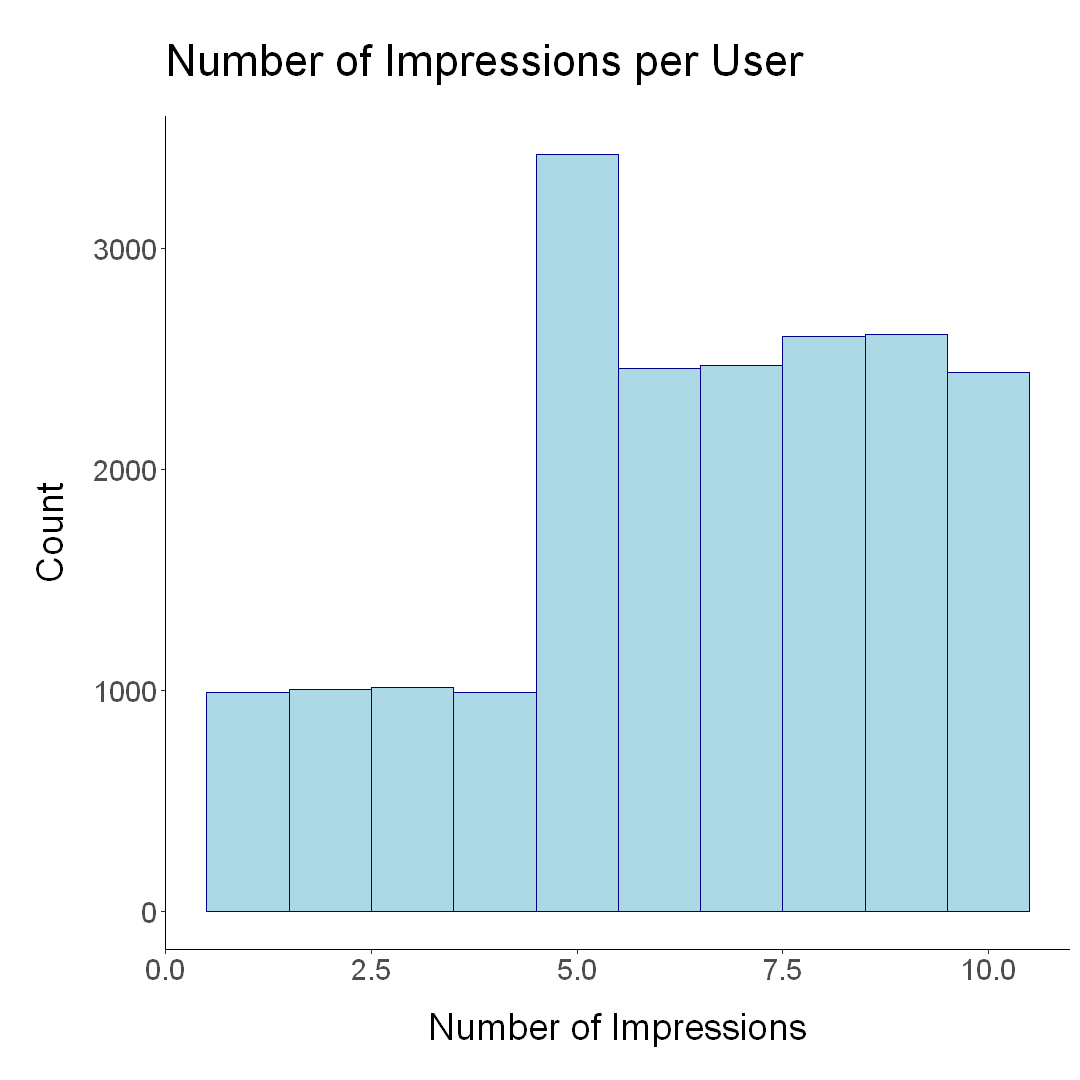

In [126]:
ggplot(data = ab, aes(x = total_user_impressions)) +
  geom_histogram(bins = 10, color = 'darkblue', fill = 'lightblue') +
  labs(
        x = "Number of Impressions",
        y = "Count",
        title = "Number of Impressions per User"
    ) + 
    theme_classic() +
    theme(text = element_text(size = 22)) + 
    theme(plot.title = element_text(margin = margin(20,0,20,0))
        , axis.title.x = element_text(margin = margin(15,0,15,0)) 
        , axis.title.y = element_text(margin = margin(0,15,0,15)))

Above we see that the highest number of users saw the ad 5 times, most users saw the ad/psa 5 or more times. Again, this hasn't started considering the number of users who have seen the ad versus psa or whether they made a purchase. The range of these data show that all users have seen the content at least once, and no one saw the product content more than 10 times. 

---
## Analysis

### Descriptive Statistics

In [99]:
# Group by test group and summarize
conversion_rates <- ab %>%
  group_by(test_group) %>%
  summarize(conversion_rate = mean(converted) 
            , std_deviation = sd(converted)
            , std_error = sd(converted)/sqrt(n())) %>%
  tidyr::pivot_longer(cols = c(conversion_rate, std_deviation, std_error)
                      , names_to = "measure"
                      , values_to = "value")

# Display results rounded to 3 decimal places  
print(conversion_rates, digits = 3)

# A tibble: 6 x 3
  test_group measure           value
  <chr>      <chr>             <dbl>
1 ad         conversion_rate 0.0666 
2 ad         std_deviation   0.249  
3 ad         std_error       0.00227
4 psa        conversion_rate 0.0323 
5 psa        std_deviation   0.177  
6 psa        std_error       0.00198


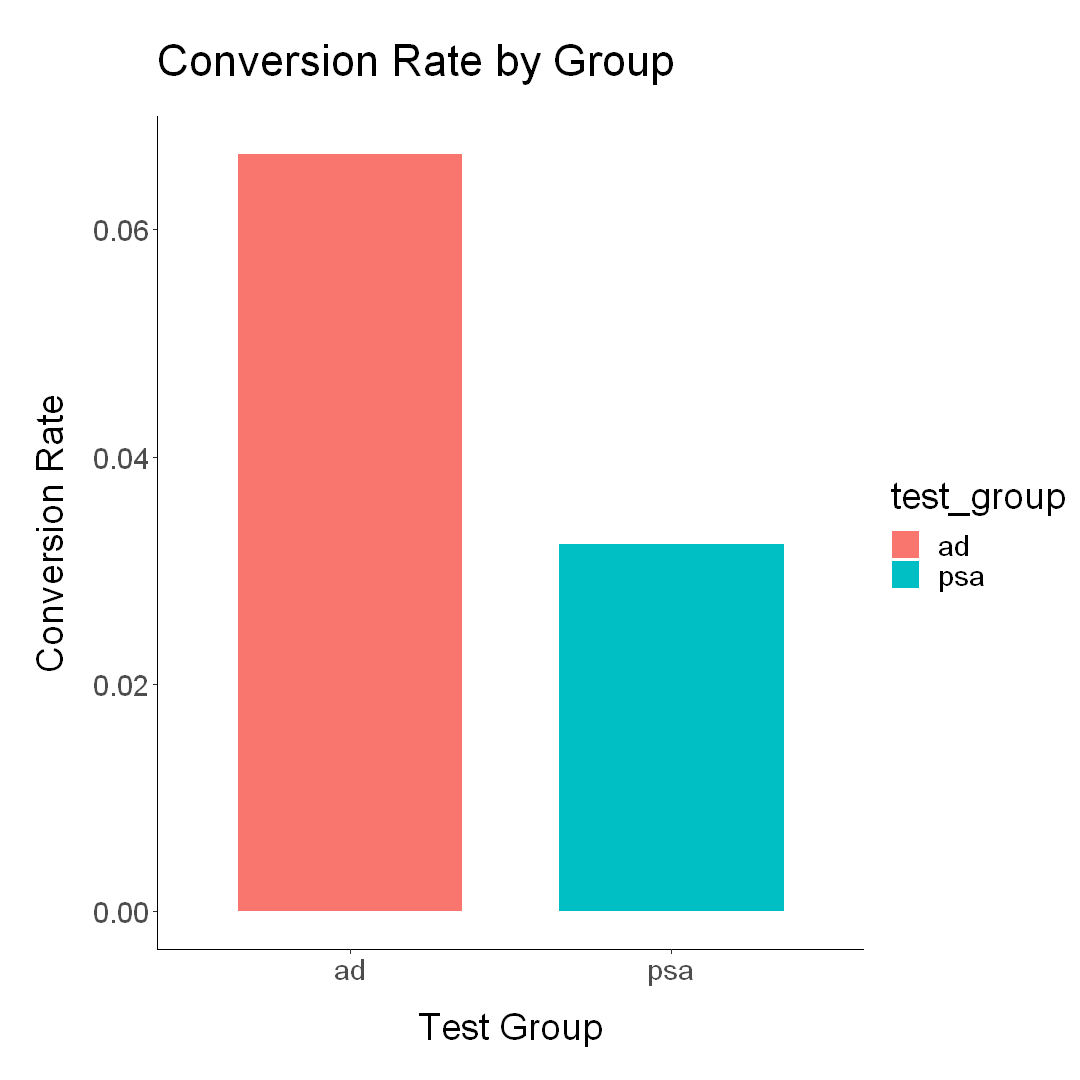

In [129]:
ab$converted_numeric <- as.numeric(ab$converted)

# Create the bar plot
ggplot(ab, aes(x = test_group, y = converted_numeric)) +
  stat_summary(fun = "mean", geom = "bar", position = "dodge", 
               aes(fill = test_group), width = 0.7) +
  # stat_summary(fun.data = "mean_se", width = 0.4, geom="errorbar") +
  labs(title = "Conversion Rate by Group",
       x = "Test Group",
       y = "Conversion Rate") +
  theme_classic() +
    theme(text = element_text(size = 22)) + 
    theme(plot.title = element_text(margin = margin(20,0,20,0))
        , axis.title.x = element_text(margin = margin(15,0,15,0)) 
        , axis.title.y = element_text(margin = margin(0,15,0,15)))

The above graph shows the Conversion Rate by group, where the PSA is our control group and the ad is our treatment group. 

--- 
### Bayesian Analysis
To perform the Bayesian Analysis, we need to separate the impressions that were converted and those that were not converted. We can also look at the descriptive statistics to get a sense of the conversions between the ad and the psa. 

In [127]:
conversion_trues <- aggregate(converted ~ test_group, data = ab, FUN = function(x) sum(x))

print(conversion_trues)
ad.true = conversion_trues[1, 2]
psa.true = conversion_trues[2, 2]

  test_group converted
1         ad       803
2        psa       257


In [128]:
conversion_falses <- aggregate(converted ~ test_group, data = ab, FUN = function(x) sum(!x))

print(conversion_falses)
ad.false = conversion_falses[1, 2]
psa.false = conversion_falses[2, 2]

  test_group converted
1         ad     11250
2        psa      7690


In following with the convention that we're using with the Beta distributions, the conversions = True would be our $\alpha$ and conversions = False would the the $\beta$. Furthermore, we've established the Ad as group A, and the PSA as group B. 

$\alpha$<sub>likelihood of Ad</sub> == _ad.true_

$\beta$<sub>likelihood of Ad</sub> == _ad.false_



$\alpha$<sub>likelihood of PSA</sub> == _psa.true_

$\beta$<sub>likelihood of PSA</sub> == _psa.false_



---

Returning to the relationship between the likelihoods, priors, and posteriors from above, the relationship we're using is: 

**Beta($\alpha$<sub>posterior</sub>, $\beta$<sub>posterior</sub>) = Beta($\alpha$<sub>prior</sub> + $\alpha$<sub>likelihood</sub>, $\beta$<sub>prior</sub> + $\beta$<sub>likelihood</sub>)**


We initially established that our Priors would be approximating a 3% conversion, using the Beta(3, 97):<br>
$\alpha$<sub>prior</sub> = 3<br>
$\beta$<sub>prior</sub> = 97


So now we can establish our two variants, for the Ad and the PSA: 
<br><br>
Our Ad will be represented by:<br>
**Beta($\alpha$<sub>posterior of Ad</sub>, $\beta$<sub>posterior of Ad</sub>) = Beta($\alpha$<sub>prior</sub> + $\alpha$<sub>likelihood of Ad</sub>, $\beta$<sub>prior</sub> + $\beta$<sub>likelihood of Ad</sub>)**

And our PSA will be represented by:<br>
**Beta($\alpha$<sub>posterior of PSA</sub>, $\beta$<sub>posterior of PSA</sub>) = Beta($\alpha$<sub>prior</sub> + $\alpha$<sub>likelihood of PSA</sub>, $\beta$<sub>prior</sub> + $\beta$<sub>likelihood of PSA</sub>)** 

---
**Beta($\alpha$<sub>posterior of Ad</sub>, $\beta$<sub>posterior of Ad</sub>) = Beta(3 + _ad.true_, 97 + _ad.false_)**
<br>

and <br>

**Beta($\alpha$<sub>posterior of PSA</sub>, $\beta$<sub>posterior of PSA</sub>) = Beta(3 + _psa.true_, 97 + _psa.false_)**

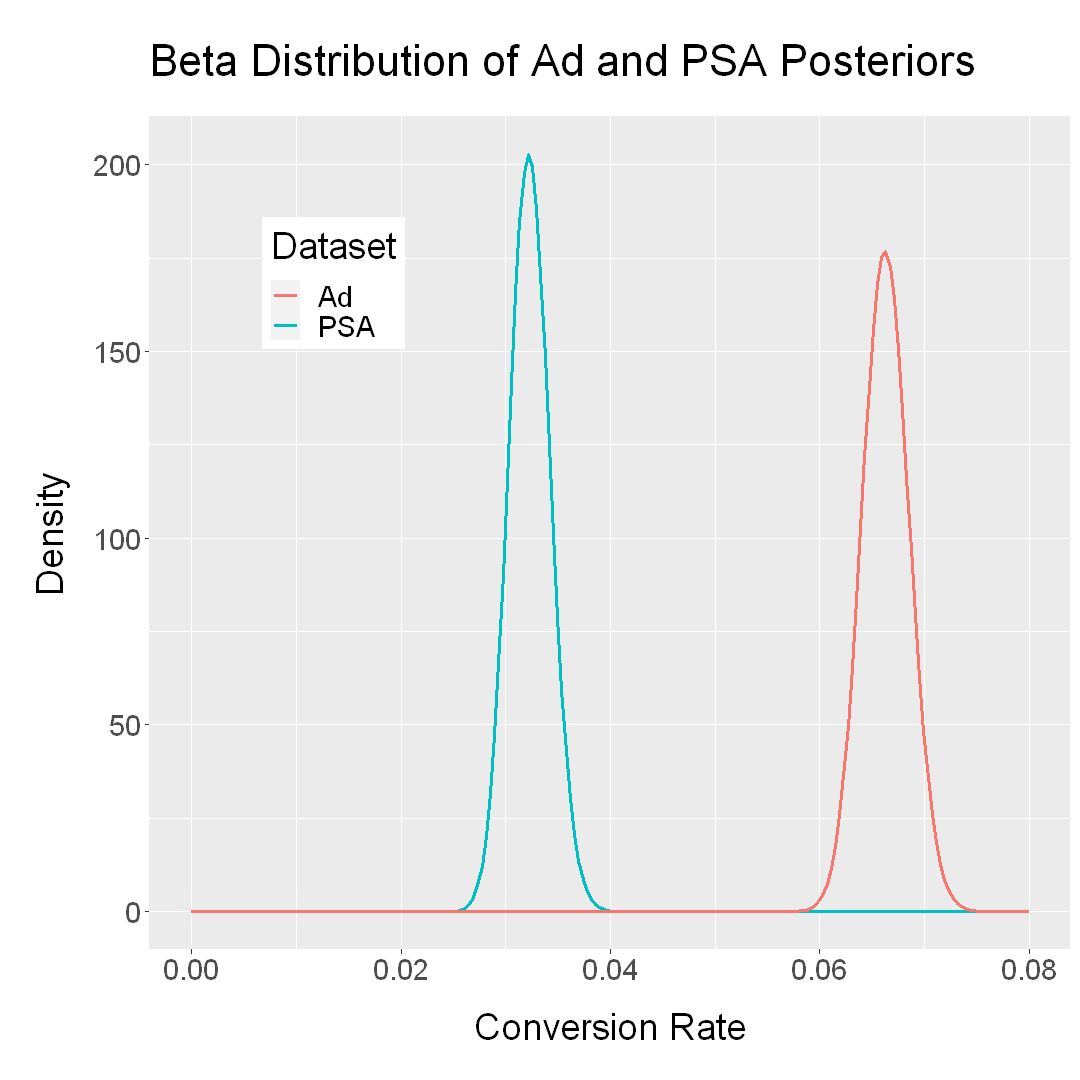

In [247]:
# define range
p <- seq(0, .08, length = 200)

# create a plot of the Beta of 3, 97
alpha.prior <- 3
beta.prior <- 97

df_ad <- data.frame(p, y = dbeta(p, alpha.prior + ad.true, beta.prior + ad.false))
df_psa <- data.frame(p, y = dbeta(p, alpha.prior + psa.true, beta.prior + psa.false))

options(repr.plot.width =9, repr.plot.height =9)


ggplot() +
    geom_line(data = df_psa, aes(x = p, y = y, color = "PSA"), linewidth = 1) +
    geom_line(data = df_ad, aes(x = p, y = y, color = "Ad"), linewidth = 1) +
    labs(
        x = "Conversion Rate"
        , y = "Density"
        , title = "Beta Distribution of Ad and PSA Posteriors"
        , color = "Dataset"
    ) + 
    theme(text = element_text(size = 22)
        , legend.position = c(0.2, 0.8)
        , plot.title = element_text(margin = margin(20,0,20,0))
        , axis.title.x = element_text(margin = margin(15,0,15,0)) 
        , axis.title.y = element_text(margin = margin(0,15,0,15)))
    

Next, I want to know what is the conversion rate that produces the maximum number of conversions in each distribution. 

In [318]:
max.ad <- df_ad[1][df_ad[2]==max(df_ad[2])]
max.psa <- df_psa[1][df_psa[2]==max(df_psa[2])]



cat(sprintf("The maximum conversion rates are as follows: The PSA conversion was %f, and the Ad conversion was %f.\n", max.psa, max.ad))

The maximum conversion rates are as follows: The PSA conversion was 0.032161, and the Ad conversion was 0.066332.


### Results

It is evident that the distribution for the Ad campaign is higher in all cases than the PSA. There is always the potential for variation in the data, and in such cases we can use a Monte Carlo simulation to add more variation to each of the samples. 

The rbeta function in R is a random number generating function, and it allows us to collect samples from each variant. Ultimately, with the simulation over 100000 trials, not only can we determine whether the Ad campaign is better than the PSA, but we can also determine how much better it is. 

In [283]:
# Number of trials for the Monte Carlo
set.seed(42)

n.trials <- 100000

ad.samples <- rbeta(n.trials, alpha.prior + ad.true, beta.prior + ad.false)
psa.samples <- rbeta(n.trials, alpha.prior + psa.true, beta.prior + psa.false)



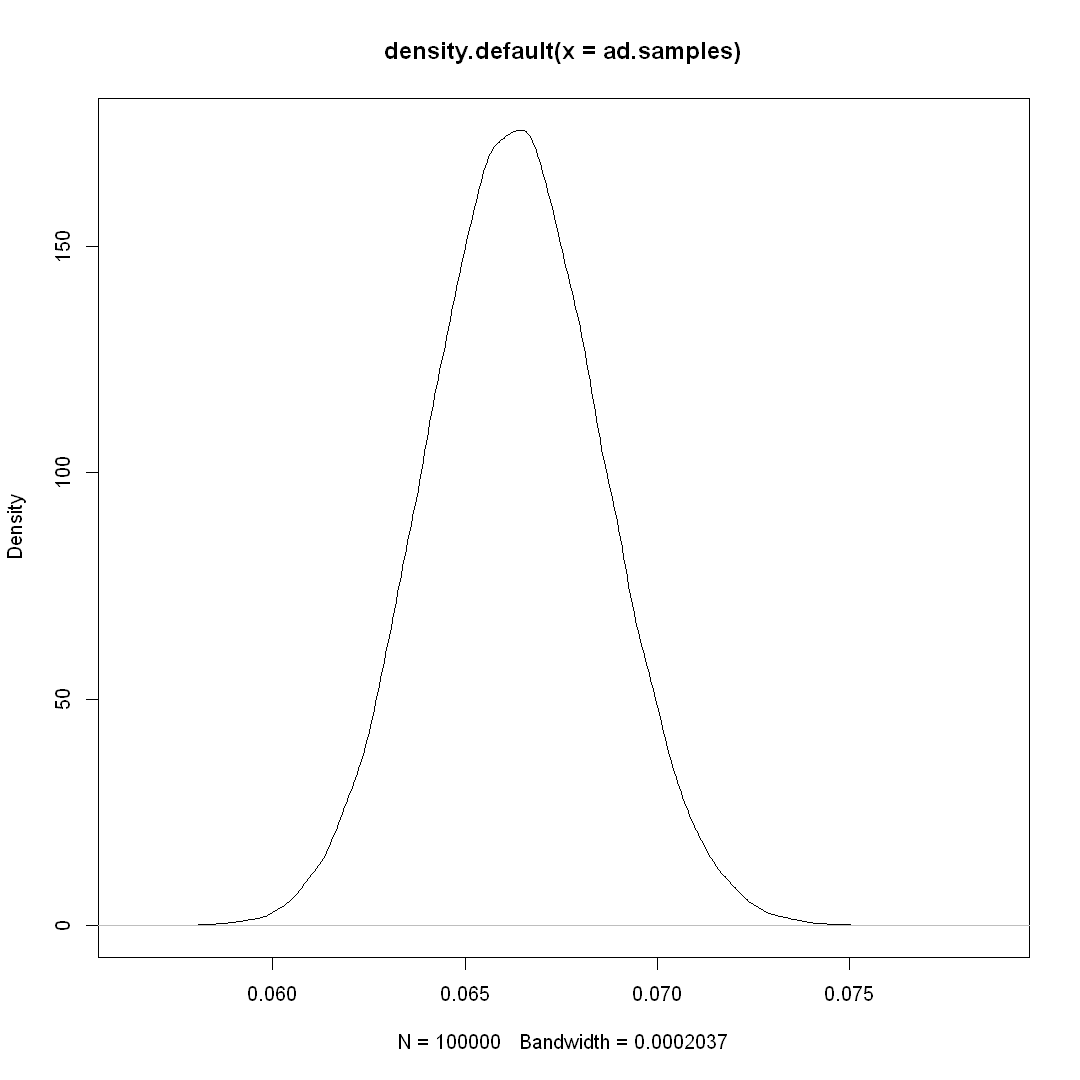

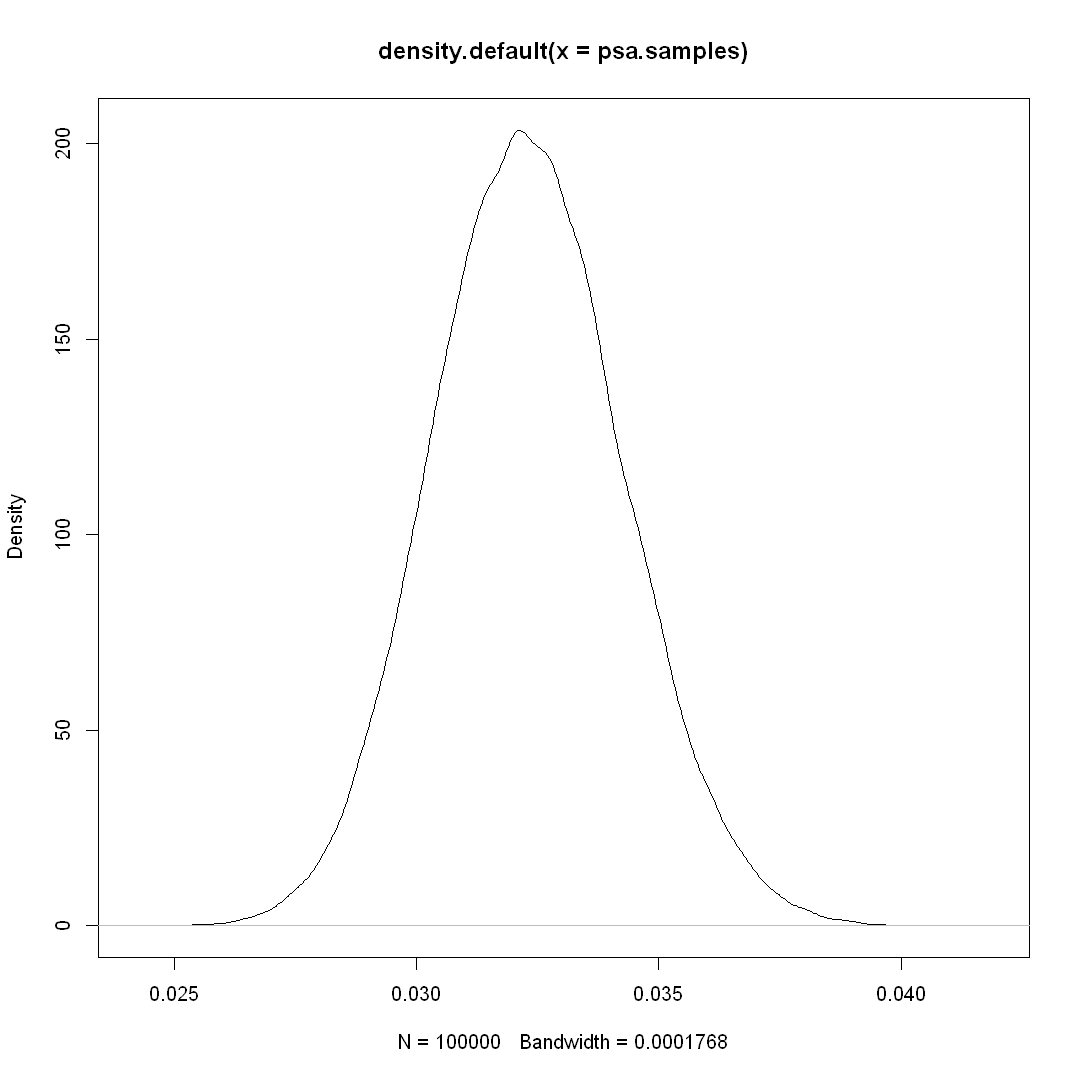

In [309]:
ad_d <- density(ad.samples)
psa_d <- density(psa.samples)


plot(ad_d)
plot(psa_d)

In [320]:
max_ad <- ad_d$x[which.max(ad_d$y)]
max_psa <- psa_d$x[which.max(psa_d$y)]

cat(sprintf("The maximum conversion rates are as follows: The PSA conversion was %f, and the Ad conversion was %f.\n", max_psa, max_ad))

The maximum conversion rates are as follows: The PSA conversion was 0.032123, and the Ad conversion was 0.066454.


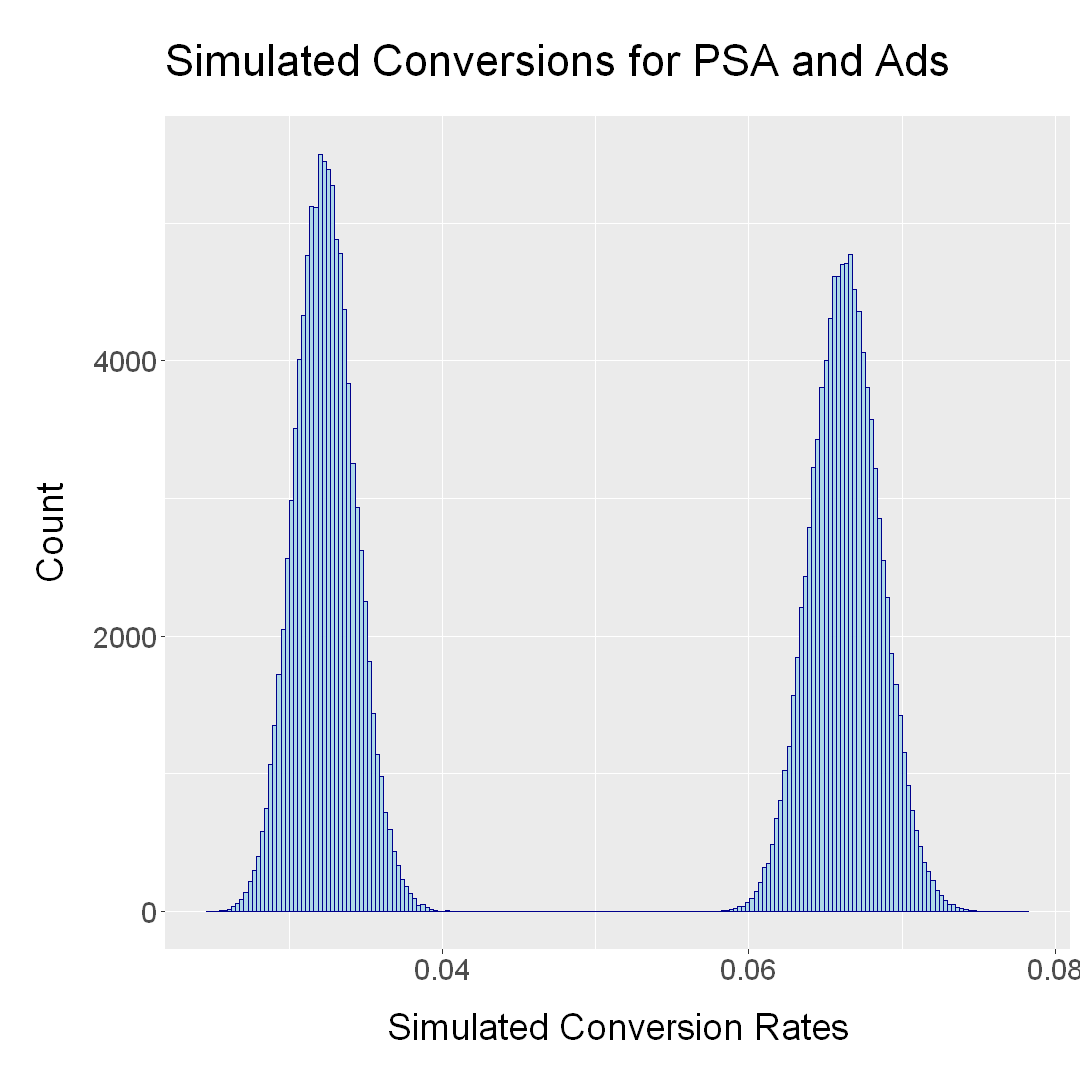

In [284]:
ad_samples = data.frame(ad.samples)
psa_samples = data.frame(psa.samples)

ggplot() +
  geom_histogram(data = ad_samples, aes(x = ad.samples), bins = 200, color = 'darkblue', fill = 'lightblue') +
  geom_histogram(data = psa_samples, aes(x = psa.samples), bins = 200, color = 'darkblue', fill = 'lightblue') +
  labs(
        x = "Simulated Conversion Rates",
        y = "Count",
        title = "Simulated Conversions for PSA and Ads"
    ) + 
    theme(text = element_text(size = 22)) + 
    theme(plot.title = element_text(margin = margin(20,0,20,0))
        , axis.title.x = element_text(margin = margin(15,0,15,0)) 
        , axis.title.y = element_text(margin = margin(0,15,0,15)))

So at this point we can see that the simulated conversion rates are still very similar to those from the original values we used.

- Sampled Ad Conversion: 6.633%
- Simulated Ad Conversion: 6.645%

- Sampled PSA Conversion: 3.216%
- Simulated PSA Conversion: 3.212%

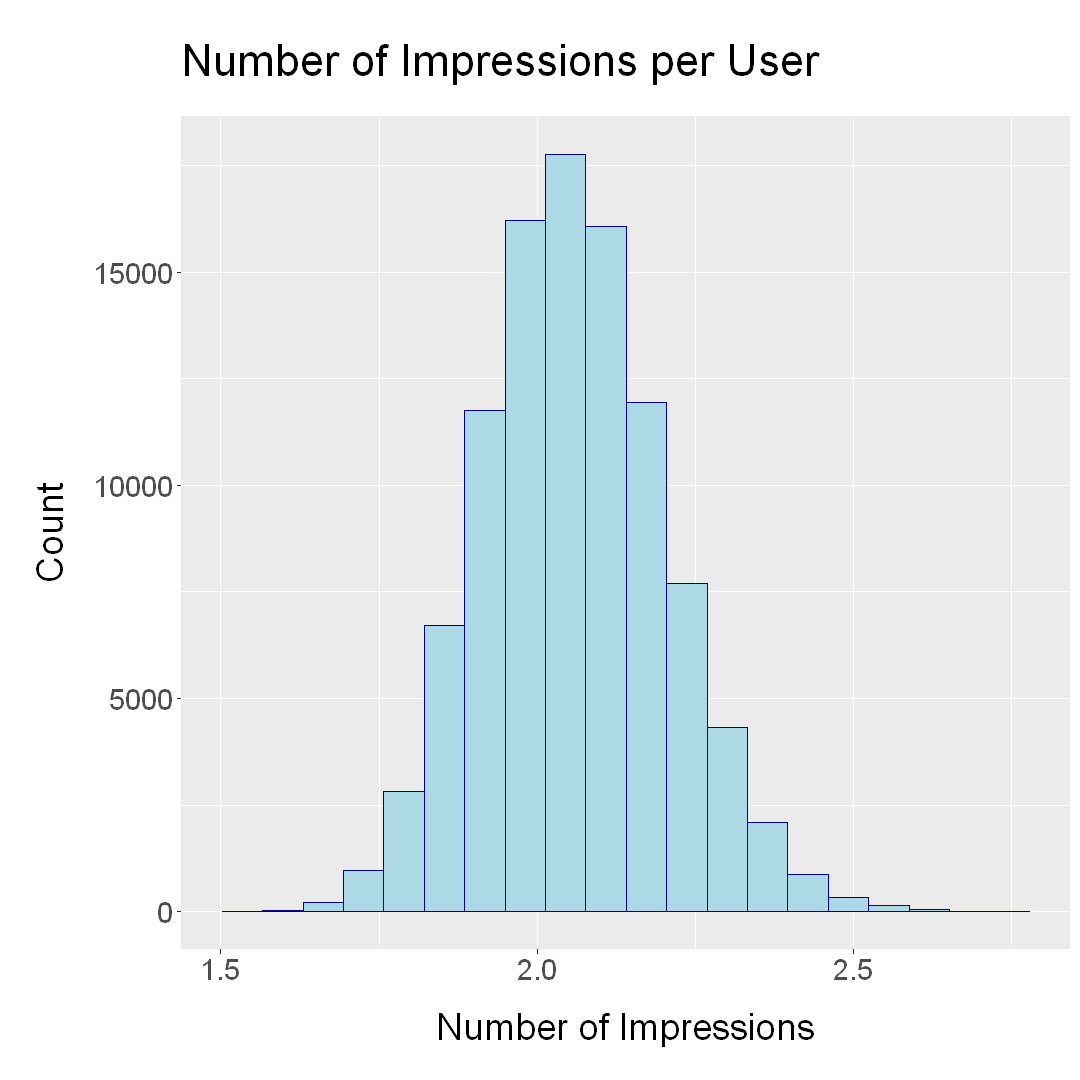

In [266]:
df_samples = data.frame(ad.samples/psa.samples)

ggplot(data = df_samples, aes(x = ad.samples/psa.samples)) +
  geom_histogram(bins = 20, color = 'darkblue', fill = 'lightblue') +
  labs(
        x = "Number of Impressions",
        y = "Count",
        title = "Number of Impressions per User"
    ) + 
    theme(text = element_text(size = 22)) + 
    theme(plot.title = element_text(margin = margin(20,0,20,0))
        , axis.title.x = element_text(margin = margin(15,0,15,0)) 
        , axis.title.y = element_text(margin = margin(0,15,0,15)))

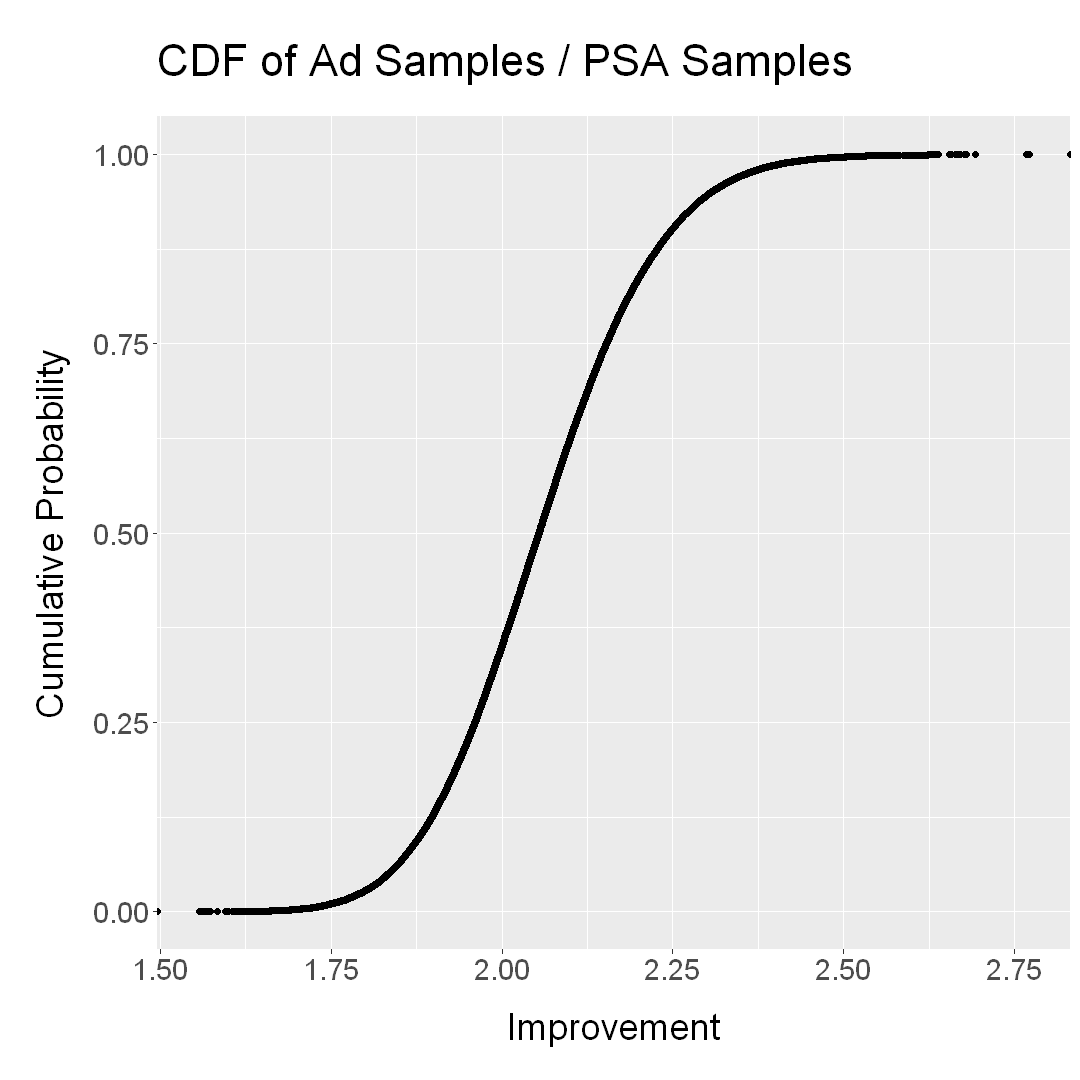

In [202]:
ggplot(data = df_samples, aes(x = ad.samples/psa.samples)) + 
    stat_ecdf(geom="point") + 
    labs(
        x = "Improvement",
        y = "Cumulative Probability",
        title = "CDF of Ad Samples / PSA Samples"
    ) + 
    theme(text = element_text(size = 22)) + 
    theme(plot.title = element_text(margin = margin(20,0,20,0))
        , axis.title.x = element_text(margin = margin(15,0,15,0)) 
        , axis.title.y = element_text(margin = margin(0,15,0,15)))

From the previous two figures, what is important to notice is that the minimum in each of the graphs is above 1.0. A value of less than 1.0 would indicate that there is a possibility when the PSA outperforms the new Ad campaign. What both of these indicate is that the Ad campaign is slightly over 2 times better than maintaining the current PSA. This shouldn't be a surprise, looking back at the Posterior Beta Distributions, there is not overlap in the two at all, and the Monte Carlo simulation performed 100,000 times did not yield any scenarios where the PSA could outperform the Ad. 

The benefit of using the simulation is similar to achieving a larger sample size. By including variation in the sampling, we can better predict the true probability of conversion using the ad or psa in this campaign. 

### Considerations

How much did the priors influence the outcome?
Because the priors we used were 3 and 97, denoting 3 conversions and 97 nonconversions, the total influence per Ad and PSA campaign was 100. For the ad campaign, there were a total of 12053 recorded incidences, and 7947 for the PSA. When changing the prior to naive 0s, the outcome is not particularly different, since the ratios are nearly the same. If I had stronger information, such as knowing that there were 1000 conversions to 18940 nonconversions, there would have been a much more substantial impact on the model.

In a future study, if there is another Ad used to improve upon the existing ad, we would be able to use $\alpha$<sub>prior</sub> = 803 and $\beta$<sub>prior</sub> = 11250, since this is collected data for this Ad. However, this could substantially impact the sample of the new test ad, since we do not have any prior information about it. 

---

## Conclusion

Using Bayesian Analysis with a Monte Carlo simulation has provided us with the information showing us that not only did the Ad outperform the PSA, but it was over twice as high in its conversion rates. The simulation gave us a more robust analysis by inserting variation in 100,000 trials, reducing the impact of sampling error. Looking at the outcome of the CDF function, we can see that there were no incidences when the PSA outperformed the Ad. 

In terms of business considerations, we can see that the conversion rate was improved from 3.2% to 6.6%, over a 3% gain. This information will be useful to those who need to decide upon whether this predicted conversion is high enough to make up for the costs of running the new ad campaign. 